### Data Preparation

**Import Library**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, root_mean_squared_error
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import LSTM
from keras.models import Sequential
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping
tf.random.set_seed(42)
sns.set_theme(style="whitegrid")
import matplotlib.dates as mdates

# !pip install keras-tuner
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
import keras_tuner as kt
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop
import random

**Read the files**

In [5]:
set1 = pd.read_csv('../Data/SET_main.csv')

# This file is consist of data that have Nan values
set2 = pd.read_csv('../Data/SET_residual.csv')

sp500 = pd.read_csv('../Data/sp500_main.csv')

In [6]:
set1 = set1.set_index('Date')
set1

,ADVANC.BK,AOT.BK,BBL.BK,BDMS.BK,BH.BK,CPALL.BK,CPF.BK,CPN.BK,DELTA.BK,HMPRO.BK,INTUCH.BK,IVL.BK,KBANK.BK,KTB.BK,MINT.BK,PTT.BK,PTTEP.BK,SCC.BK,TRUE.BK,TTB.BK
Date,,,,,,,,,,,,,,,,,,,,
2014-01-02,115.707695,13.004045,112.167664,8.865041,68.680244,33.136929,22.704105,31.580967,4.015339,4.772995,36.063667,14.913610,107.741776,9.801532,15.467829,16.889353,93.353264,263.643036,5.398062,1.198794
2014-01-03,121.276527,12.870900,113.856918,8.824374,69.914032,33.136929,22.704105,31.159885,3.846470,4.633434,36.908916,14.837523,111.814484,9.864767,15.223605,16.519508,92.148727,262.951050,5.318678,1.186436
2014-01-06,124.370323,12.648986,117.235466,9.678345,69.091530,33.344040,21.773605,31.580967,3.696364,4.605521,37.190655,14.913610,116.257446,9.991237,16.363337,16.272951,89.137291,266.411011,5.477446,1.217332
2014-01-07,129.939133,13.447869,120.276161,9.556350,68.474625,33.965351,22.704105,32.844200,3.771417,4.717172,38.176777,15.446239,119.959915,10.244180,17.096024,17.320827,92.449844,269.178833,5.636212,1.229691
2014-01-08,127.464096,12.870900,119.938301,9.312360,67.446480,33.551147,22.145803,32.633663,3.790180,4.633434,38.035904,15.978869,119.959915,9.991237,16.526155,17.567392,94.256668,271.254791,5.398062,1.248229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-03,296.000000,61.209999,150.500000,26.000000,212.000000,63.750000,24.200001,60.500000,151.000000,9.900000,102.500000,24.600000,153.500000,20.299999,27.750000,32.250000,128.500000,184.000000,11.900000,1.790000
2024-12-04,289.000000,61.500000,151.500000,25.750000,211.000000,64.000000,24.100000,60.500000,151.000000,9.700000,100.000000,24.500000,155.000000,20.600000,28.000000,32.250000,128.000000,183.000000,12.100000,1.780000
2024-12-06,295.000000,61.000000,152.000000,25.500000,210.000000,63.000000,24.100000,60.250000,150.500000,9.700000,102.500000,25.250000,156.000000,20.700001,27.500000,32.250000,128.000000,183.500000,11.800000,1.830000


In [7]:
set1.shape

(2662, 20)

### Modeling 

**Data Preparation**

*Creating the function*

In [11]:
# Creating a function for data preparation 
def data_prep(df, stock_columns, test_size, window_size):
    results = {}
    
    for stock in stock_columns:
        print(f"Stock: {stock}")

        df.index = pd.to_datetime(df.index)
        
        # Plot training and test sets
        plt.figure(figsize=(12, 3))
        plt.plot(df.index[:-test_size], df[stock][:-test_size], color='black', label="Training set")
        plt.plot(df.index[-test_size:], df[stock][-test_size:], color='blue', label="Test set")
        plt.title(f"{stock} Training and Test Sets", fontsize=15)
        plt.xlabel("Date", fontsize=12)
        plt.ylabel("Price", fontsize=12)
        
        # show only year
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  
        plt.gca().xaxis.set_major_locator(mdates.YearLocator())   
        plt.xlim(df.index.min(), df.index.max())
        plt.grid(color="lightgray")  
        plt.gca().set_facecolor("white") 
        plt.legend(loc="upper left")
        plt.tight_layout() 
        plt.show()

        # Scale the data 
        scaler = MinMaxScaler()
        
        # Window size (e.g., 30 days)
        window_size = window_size

        # Training set
        train_data = df[stock][:-test_size].values
        train_data = scaler.fit_transform(train_data.reshape(-1, 1))
        
        X_train, y_train = [], []
        for i in range(window_size, len(train_data)):
            X_train.append(train_data[i-window_size:i, 0])
            y_train.append(train_data[i, 0])
        
        # Testing set
        test_data = df[stock][-test_size-window_size:].values
        test_data = scaler.transform(test_data.reshape(-1, 1))
        
        X_test, y_test = [], []
        for i in range(window_size, len(test_data)):
            X_test.append(test_data[i-window_size:i, 0])
            y_test.append(test_data[i, 0])
        
        # Convert to numpy arrays to make it acceptable for the model
        X_train = np.array(X_train).reshape(-1, window_size, 1)
        X_test = np.array(X_test).reshape(-1, window_size, 1)
        y_train = np.array(y_train).reshape(-1, 1)
        y_test = np.array(y_test).reshape(-1, 1)

        print(f'{stock} - X_train Shape: {X_train.shape}, y_train Shape: {y_train.shape}')
        print(f'{stock} - X_test Shape: {X_test.shape}, y_test Shape: {y_test.shape}')
        
        # Store results
        results[stock] = {
            'X_train': X_train,
            'X_test': X_test,
            'y_train': y_train,
            'y_test': y_test}
    
    return results


*Applying the function for SET1 (Stock exchange of Thailand)*

In [13]:
stock_columns = list(set1.columns)
test_size = 360 
window_size = 60

Stock: ADVANC.BK


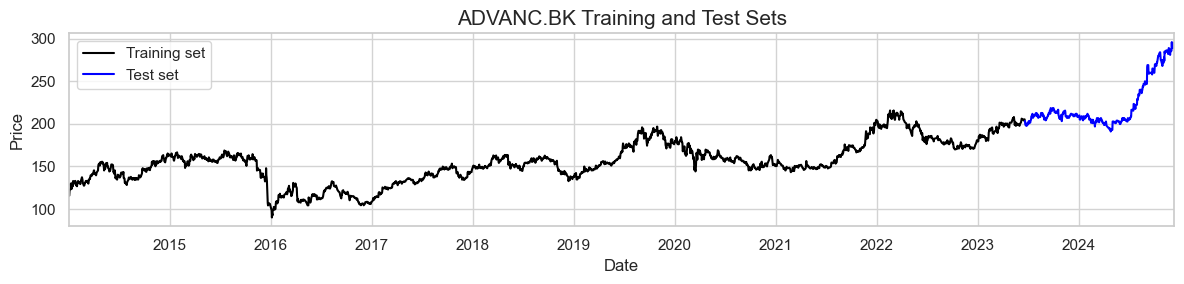

ADVANC.BK - X_train Shape: (2242, 60, 1), y_train Shape: (2242, 1)
ADVANC.BK - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: AOT.BK


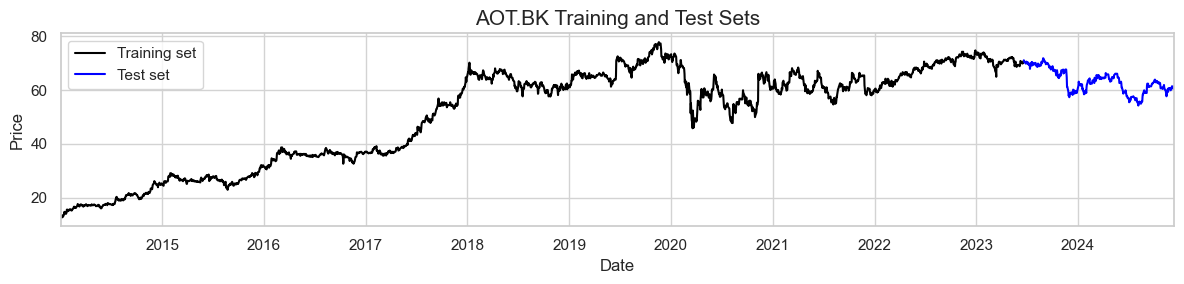

AOT.BK - X_train Shape: (2242, 60, 1), y_train Shape: (2242, 1)
AOT.BK - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: BBL.BK


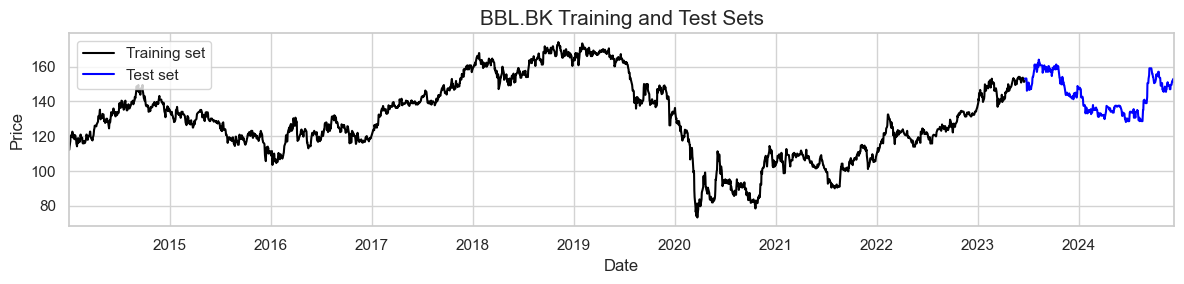

BBL.BK - X_train Shape: (2242, 60, 1), y_train Shape: (2242, 1)
BBL.BK - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: BDMS.BK


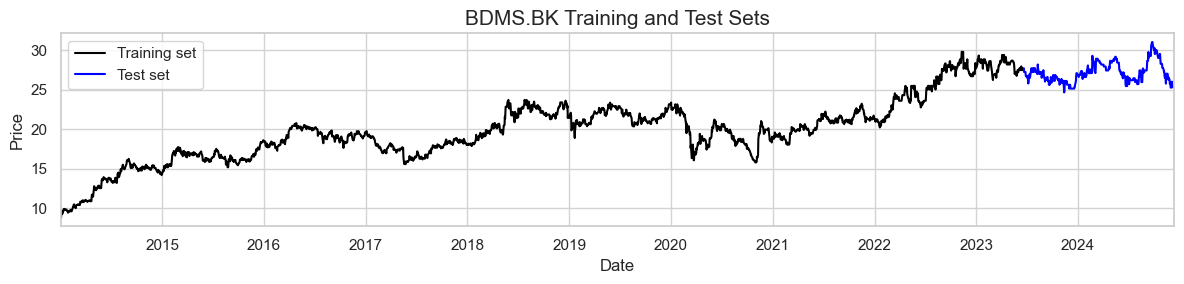

BDMS.BK - X_train Shape: (2242, 60, 1), y_train Shape: (2242, 1)
BDMS.BK - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: BH.BK


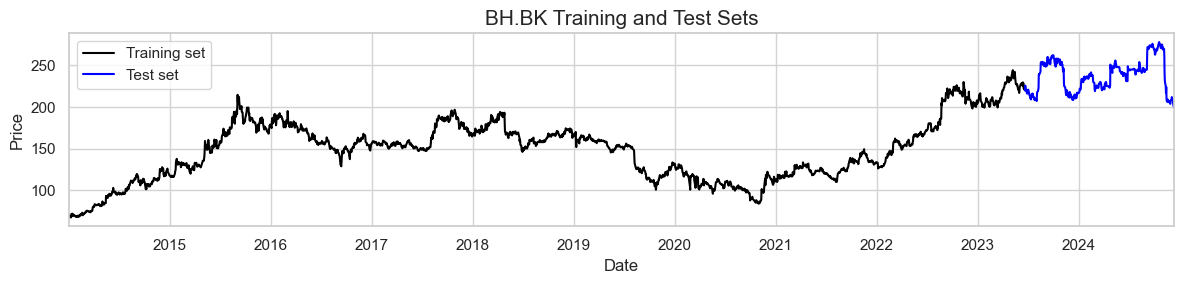

BH.BK - X_train Shape: (2242, 60, 1), y_train Shape: (2242, 1)
BH.BK - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: CPALL.BK


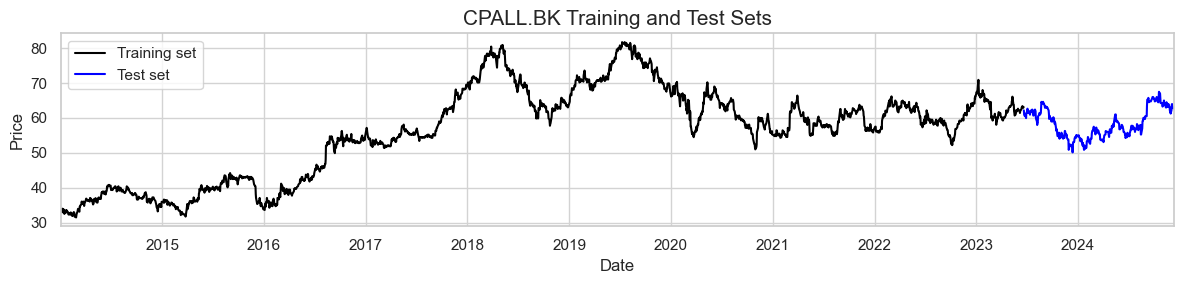

CPALL.BK - X_train Shape: (2242, 60, 1), y_train Shape: (2242, 1)
CPALL.BK - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: CPF.BK


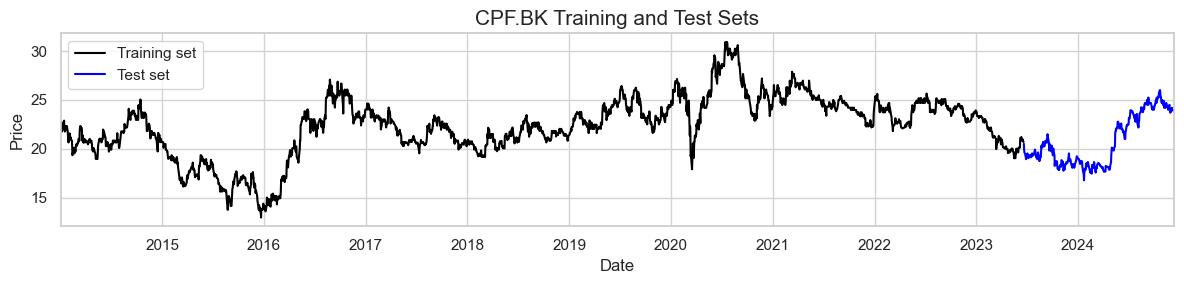

CPF.BK - X_train Shape: (2242, 60, 1), y_train Shape: (2242, 1)
CPF.BK - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: CPN.BK


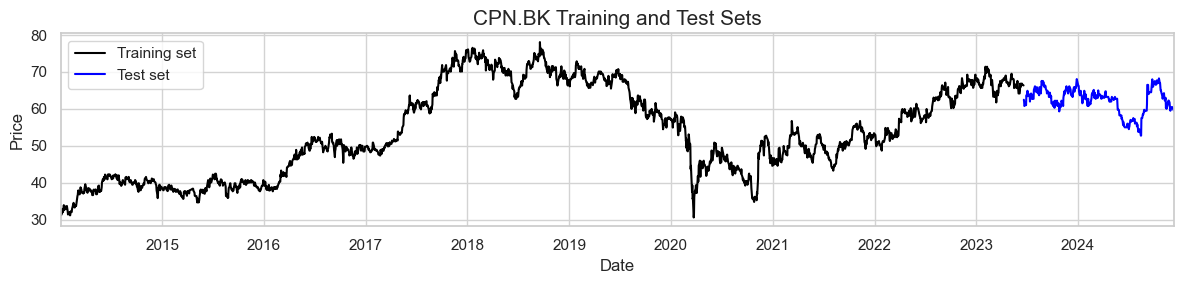

CPN.BK - X_train Shape: (2242, 60, 1), y_train Shape: (2242, 1)
CPN.BK - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: DELTA.BK


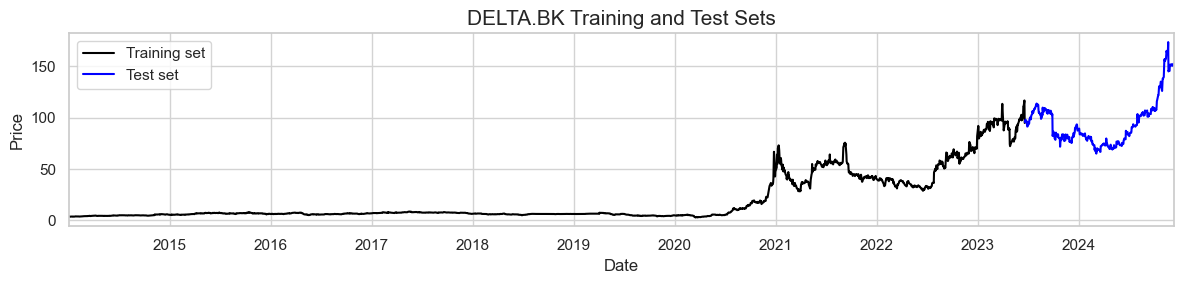

DELTA.BK - X_train Shape: (2242, 60, 1), y_train Shape: (2242, 1)
DELTA.BK - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: HMPRO.BK


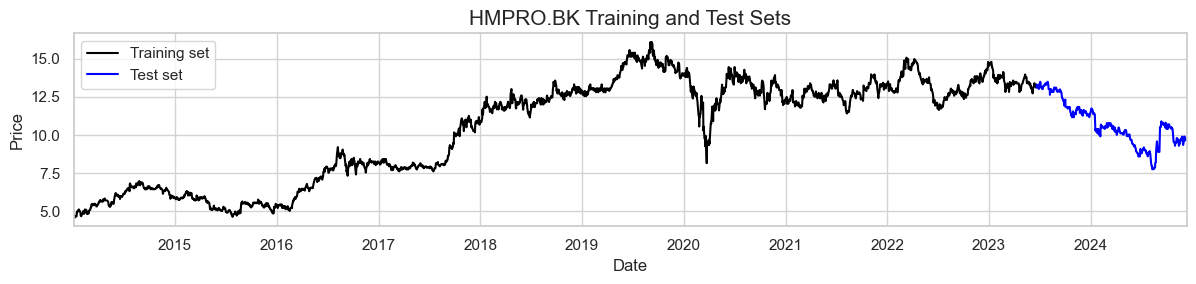

HMPRO.BK - X_train Shape: (2242, 60, 1), y_train Shape: (2242, 1)
HMPRO.BK - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: INTUCH.BK


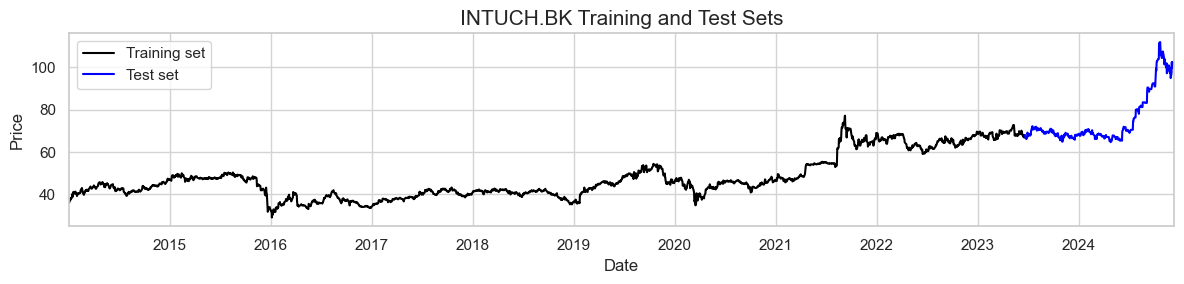

INTUCH.BK - X_train Shape: (2242, 60, 1), y_train Shape: (2242, 1)
INTUCH.BK - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: IVL.BK


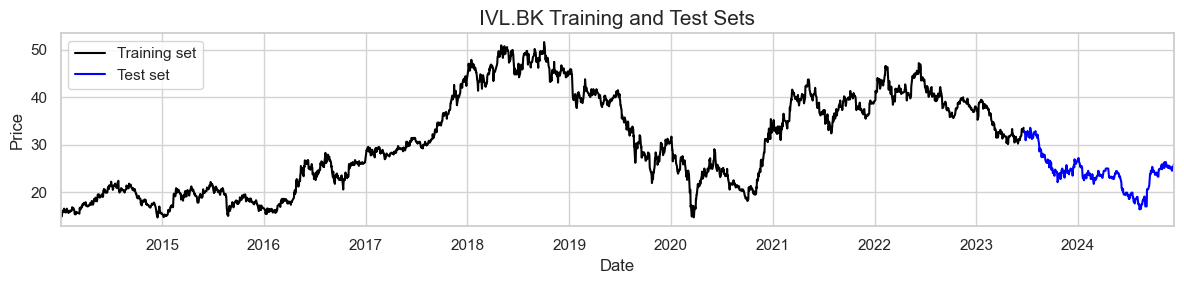

IVL.BK - X_train Shape: (2242, 60, 1), y_train Shape: (2242, 1)
IVL.BK - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: KBANK.BK


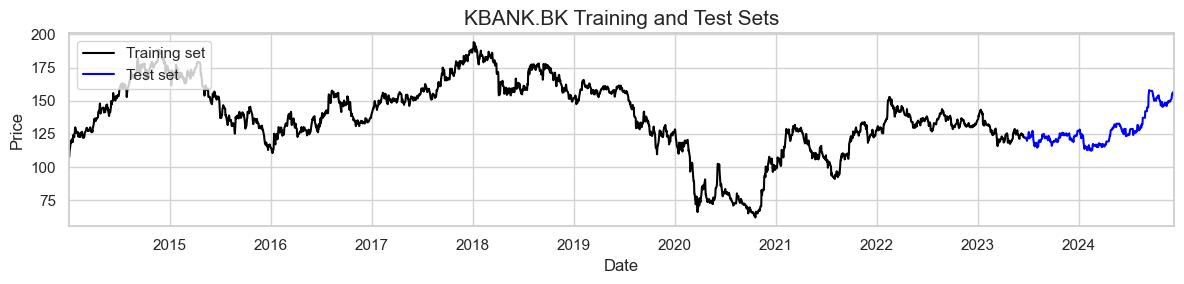

KBANK.BK - X_train Shape: (2242, 60, 1), y_train Shape: (2242, 1)
KBANK.BK - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: KTB.BK


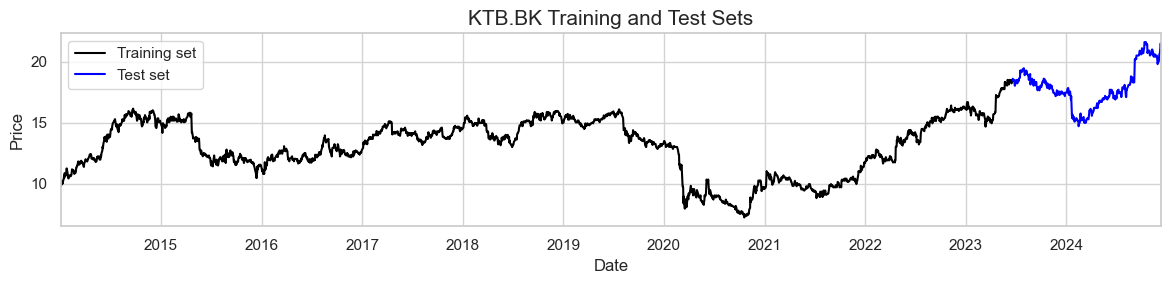

KTB.BK - X_train Shape: (2242, 60, 1), y_train Shape: (2242, 1)
KTB.BK - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: MINT.BK


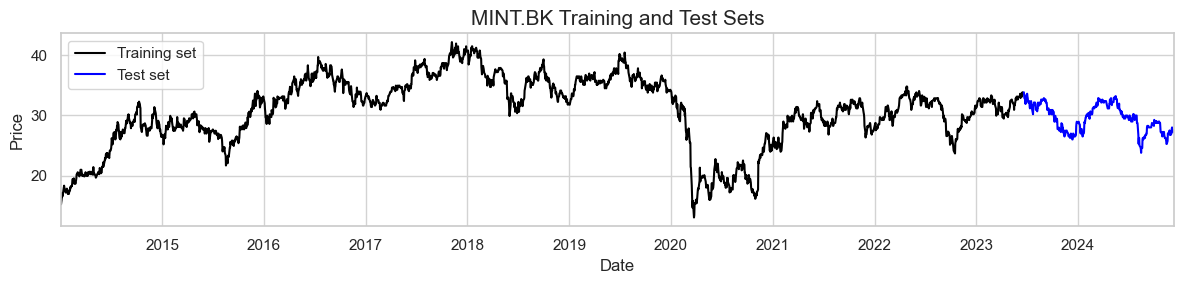

MINT.BK - X_train Shape: (2242, 60, 1), y_train Shape: (2242, 1)
MINT.BK - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: PTT.BK


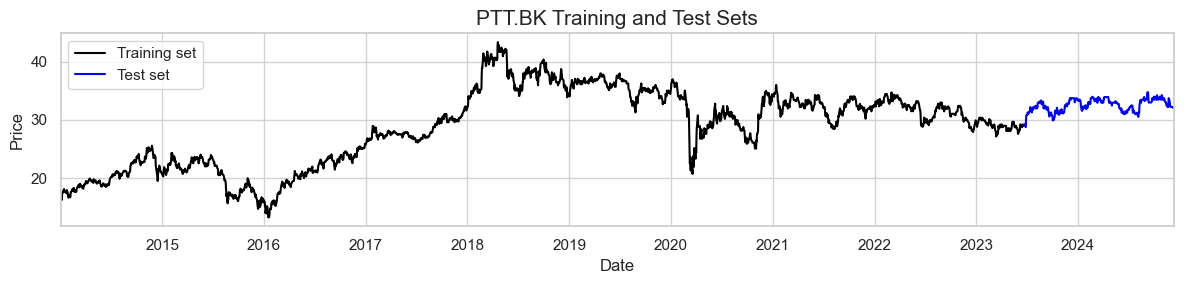

PTT.BK - X_train Shape: (2242, 60, 1), y_train Shape: (2242, 1)
PTT.BK - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: PTTEP.BK


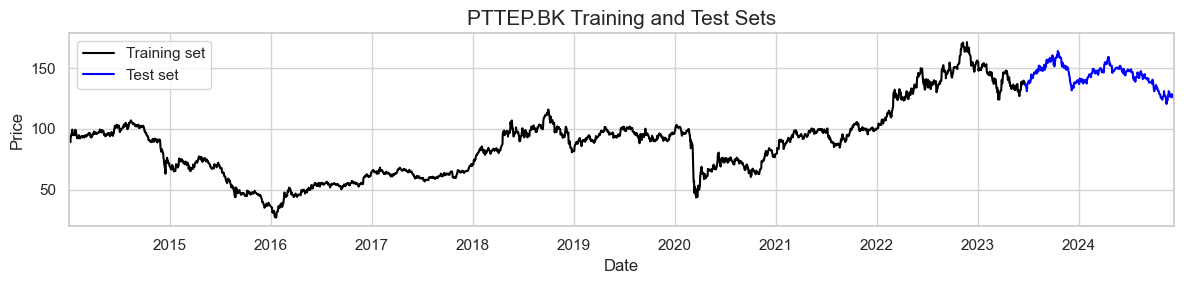

PTTEP.BK - X_train Shape: (2242, 60, 1), y_train Shape: (2242, 1)
PTTEP.BK - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: SCC.BK


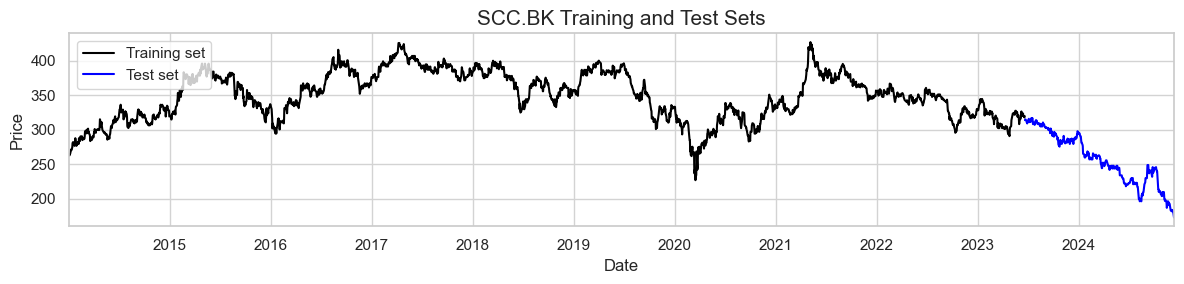

SCC.BK - X_train Shape: (2242, 60, 1), y_train Shape: (2242, 1)
SCC.BK - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: TRUE.BK


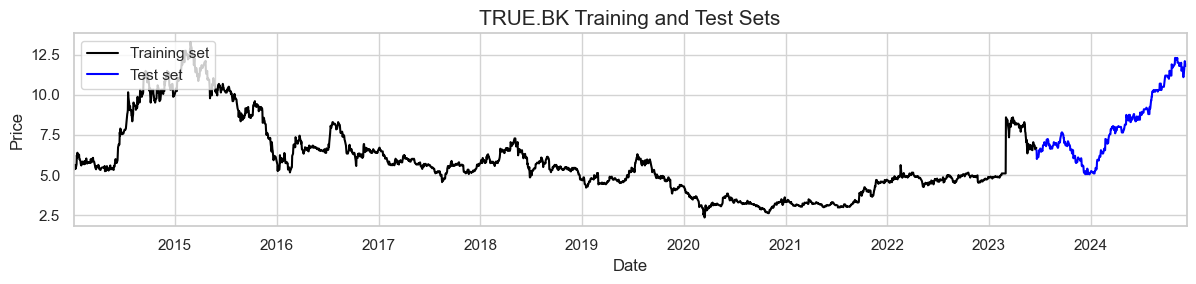

TRUE.BK - X_train Shape: (2242, 60, 1), y_train Shape: (2242, 1)
TRUE.BK - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)
Stock: TTB.BK


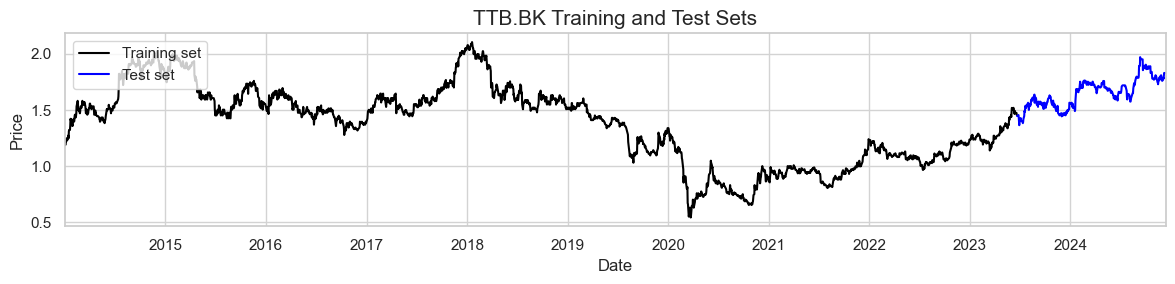

TTB.BK - X_train Shape: (2242, 60, 1), y_train Shape: (2242, 1)
TTB.BK - X_test Shape: (360, 60, 1), y_test Shape: (360, 1)


In [14]:
# data preparation for dataframe set1
# Adjusting the portfolio for 1 year time frame 
results = data_prep(df=set1, stock_columns=stock_columns, test_size=test_size, window_size=window_size)

**Create function for LSTM model and Training**

*Create the model*

In [17]:
# Set random seeds
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

def define_model(units_lstm_1, units_lstm_2, units_lstm_3, dropout_1, dropout_2, dropout_3, dense_units, optimizer_name):
    input1 = Input(shape=(window_size, 1))
    
    # First LSTM layer 
    x = LSTM(units=units_lstm_1, return_sequences=True)(input1)  
    x = Dropout(dropout_1)(x)
    
    # Second LSTM layer
    x = LSTM(units=units_lstm_2, return_sequences=True)(x)
    x = Dropout(dropout_2)(x)
    
    # Third LSTM layer
    x = LSTM(units=units_lstm_3)(x)
    x = Dropout(dropout_3)(x)
    
    # Dense layer with dynamic units
    x = Dense(dense_units, activation='relu')(x)
    
    # Output layer
    dnn_output = Dense(1)(x)

    # Map optimizer name to optimizer object
    optimizer_mapping = {
        'adam': Adam(),
        'nadam': Nadam(),
        'rmsprop': RMSprop()
    }
    optimizer = optimizer_mapping.get(optimizer_name, Adam())
    
    # Compile the model
    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    model.summary()
    
    return model

**Find the best hyperparameters**

In [19]:
# Function to Find the best hyperparameters
input1 = Input(shape=(window_size , 1))
def build_model(hp):
    # Tune the number of units in LSTM layers
    x = LSTM(units=hp.Int('units_layer_1', min_value=32, max_value=128, step=32), return_sequences=True)(input1)
    x = Dropout(hp.Float('dropout_layer_1', min_value=0.1, max_value=0.5, step=0.1))(x)

    x = LSTM(units=hp.Int('units_layer_2', min_value=32, max_value=128, step=32), return_sequences=True)(x)
    x = Dropout(hp.Float('dropout_layer_2', min_value=0.1, max_value=0.5, step=0.1))(x)

    x = LSTM(units=hp.Int('units_layer_3', min_value=32, max_value=128, step=32))(x)
    x = Dropout(hp.Float('dropout_layer_3', min_value=0.1, max_value=0.5, step=0.1))(x)

    x = Dense(hp.Int('dense_units', min_value=16, max_value=64, step=16), activation='relu')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])

    # Tune the optimizer and learning rate
    optimizer = hp.Choice('optimizer', values=['adam', 'nadam', 'rmsprop'])
    model.compile(loss='mean_squared_error', 
                  optimizer=optimizer, 
                  metrics=['mean_squared_error'])

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

    return model


In [20]:
# Loop through each column 
for stock in set1.columns:
    # Recall X_train, X_test, y_train, y_test for each stock
    X_train = results[stock]['X_train']
    X_test = results[stock]['X_test']
    y_train = results[stock]['y_train']
    y_test = results[stock]['y_test']
    
    # Now you can use these variables (X_train, X_test, y_train, y_test) for further processing
    print(f"Processed {stock}: X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")

Processed ADVANC.BK: X_train shape: (2242, 60, 1), X_test shape: (360, 60, 1)
Processed AOT.BK: X_train shape: (2242, 60, 1), X_test shape: (360, 60, 1)
Processed BBL.BK: X_train shape: (2242, 60, 1), X_test shape: (360, 60, 1)
Processed BDMS.BK: X_train shape: (2242, 60, 1), X_test shape: (360, 60, 1)
Processed BH.BK: X_train shape: (2242, 60, 1), X_test shape: (360, 60, 1)
Processed CPALL.BK: X_train shape: (2242, 60, 1), X_test shape: (360, 60, 1)
Processed CPF.BK: X_train shape: (2242, 60, 1), X_test shape: (360, 60, 1)
Processed CPN.BK: X_train shape: (2242, 60, 1), X_test shape: (360, 60, 1)
Processed DELTA.BK: X_train shape: (2242, 60, 1), X_test shape: (360, 60, 1)
Processed HMPRO.BK: X_train shape: (2242, 60, 1), X_test shape: (360, 60, 1)
Processed INTUCH.BK: X_train shape: (2242, 60, 1), X_test shape: (360, 60, 1)
Processed IVL.BK: X_train shape: (2242, 60, 1), X_test shape: (360, 60, 1)
Processed KBANK.BK: X_train shape: (2242, 60, 1), X_test shape: (360, 60, 1)
Processed K

In [21]:
# Instantiate the tuner
tuner = RandomSearch(
    build_model,
    objective='val_mean_squared_error', 
    max_trials=2,  
    executions_per_trial=1,  
    directory='tuner_results',
    project_name='lstm_tuning', 
    overwrite=True)
    

**Loop for all stocks name finding best hyperparameters, fit, and evaluate the model**

In [23]:
import time 
def find_fit_eva(df, test_size, results, tuner, define_model):
    # Start the timer for the entire process
    t0 = time.time()
    
    # Initialize dictionary to store hyperparameters + predictions 
    hyperparameters_ = {}
    predictions_ = {}
    models_ = {}
    
    # Loop through each stock column in the dataframe
    for stock in df.columns:
        # Recall X_train, X_test, y_train, y_test for each stock
        X_train = results[stock]['X_train']
        X_test = results[stock]['X_test']
        y_train = results[stock]['y_train']
        y_test = results[stock]['y_test']
        
        # Hyperparameter tuning search for the current stock
        print(f"Starting tuning for {stock}...")
        tuner.search(X_train, y_train, 
                     epochs=50, 
                     batch_size=32, 
                     validation_split=0.2, 
                     verbose=1)
        
        # Get the best hyperparameters
        best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
        print(f"Best Hyperparameters for {stock}:\n {best_hyperparameters.values}")
    
        # Extract parameters values
        units_lstm_1 = best_hyperparameters['units_layer_1']
        units_lstm_2 = best_hyperparameters['units_layer_2']
        units_lstm_3 = best_hyperparameters['units_layer_3']
        dropout_1 = best_hyperparameters['dropout_layer_1']
        dropout_2 = best_hyperparameters['dropout_layer_2']
        dropout_3 = best_hyperparameters['dropout_layer_3']
        dense_units = best_hyperparameters['dense_units']
        optimizer_name = best_hyperparameters['optimizer']
    
        # Save the hyperparameters in a dictionary of DataFrames
        hyperparameters_dict = best_hyperparameters.values
        hyperparameters_[stock] = pd.DataFrame([hyperparameters_dict])
        print(hyperparameters_[stock].T) 
        
        # Define the model with the best hyperparameters
        model = define_model(units_lstm_1, units_lstm_2, units_lstm_3, dropout_1, dropout_2, dropout_3, dense_units, optimizer_name)
        
        # Train the model
        model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)
        
        # Evaluate the model
        print(f"\nEvaluating best model for {stock}")
        test_loss = model.evaluate(X_test, y_test, verbose=0)
        y_pred = model.predict(X_test) 
        print(f'Test loss for {stock}: {test_loss:.4f}')
    
        # Inverse transform predictions and true values
        scaler = MinMaxScaler()
        train_data = df[stock][:-test_size].values
        scaler.fit(train_data.reshape(-1, 1))  # Fit scaler only on training data
        y_test_true = scaler.inverse_transform(y_test.reshape(-1, 1))
        y_test_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
        train_data = scaler.transform(train_data.reshape(-1, 1))

        # Store the predicted values for the stock
        predictions_[stock] = y_test_pred
        
        # Calculate evaluation metrics
        MSE = mean_squared_error(y_test_true, y_test_pred)
        RMSE = np.sqrt(MSE)
        print(f"Test MSE for {stock}: {MSE:.4f}")
        print(f"Test RMSE for {stock}: {RMSE:.4f}")

        df.index = pd.to_datetime(df.index)
        
        # Plot the prices predicted with actual
        plt.figure(figsize=(12, 3))
        plt.plot(df.index[:-test_size], scaler.inverse_transform(train_data), color='black', label='Training Data')
        plt.plot(df.index[-test_size:], y_test_true, color='blue', label='Actual Test Data')
        plt.plot(df.index[-test_size:], y_test_pred, color='red', label='Predicted Test Data')
        plt.title(f'Model Performance on {stock} Prediction', fontsize=15)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Price', fontsize=12)
        plt.legend(loc='upper left')
        plt.show()

        # Save the images
        plt.savefig(f'../images/{stock}_prediction_chart.png', format='png')

        # Store the model for this stock
        models_[stock] = model
        
    # Time to run in seconds for the entire process
    print(f"Total time taken for the entire process: {time.time() - t0} seconds")
    
    return hyperparameters_ , predictions_ , models_


Trial 2 Complete [00h 05m 02s]
val_mean_squared_error: 0.0004020779742859304

Best val_mean_squared_error So Far: 0.0004020779742859304
Total elapsed time: 00h 08m 15s
Best Hyperparameters for ADVANC.BK:
 {'units_layer_1': 128, 'dropout_layer_1': 0.2, 'units_layer_2': 128, 'dropout_layer_2': 0.2, 'units_layer_3': 96, 'dropout_layer_3': 0.1, 'dense_units': 16, 'optimizer': 'rmsprop'}
                       0
units_layer_1        128
dropout_layer_1      0.2
units_layer_2        128
dropout_layer_2      0.2
units_layer_3         96
dropout_layer_3      0.1
dense_units           16
optimizer        rmsprop


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,113 (1.09 MB)

 Trainable params: 286,113 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - loss: 0.0591 - val_loss: 0.0030
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - loss: 0.0097 - val_loss: 0.0046
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - loss: 0.0080 - val_loss: 0.0018
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - loss: 0.0063 - val_loss: 0.0276
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - loss: 0.0052 - val_loss: 0.0167
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - loss: 0.0058 - val_loss: 0.0072
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - loss: 0.0040 - val_loss: 0.0257
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - loss: 0.0052 - val_loss: 0.0064
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - loss: 0.0033 - val_loss: 0.0016
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 0.0032 - val_loss: 0.0041
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - loss: 0.0033 - val_loss: 0.0098
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss

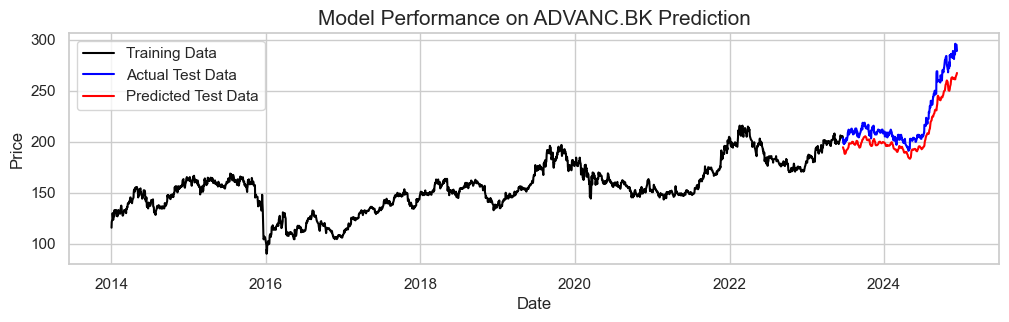

Starting tuning for AOT.BK...
Best Hyperparameters for AOT.BK:
 {'units_layer_1': 128, 'dropout_layer_1': 0.2, 'units_layer_2': 128, 'dropout_layer_2': 0.2, 'units_layer_3': 96, 'dropout_layer_3': 0.1, 'dense_units': 16, 'optimizer': 'rmsprop'}
                       0
units_layer_1        128
dropout_layer_1      0.2
units_layer_2        128
dropout_layer_2      0.2
units_layer_3         96
dropout_layer_3      0.1
dense_units           16
optimizer        rmsprop


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,113 (1.09 MB)

 Trainable params: 286,113 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - loss: 0.1012 - val_loss: 0.0812
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - loss: 0.0178 - val_loss: 0.0082
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - loss: 0.0097 - val_loss: 0.0745
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - loss: 0.0118 - val_loss: 0.0553
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 0.0082 - val_loss: 0.0045
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - loss: 0.0067 - val_loss: 0.0106
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - loss: 0.0061 - val_loss: 0.0386
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - loss: 0.0064 - val_loss: 0.0354
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - loss: 0.0057 - val_loss: 0.0058
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - loss: 0.0038 - val_loss: 0.0084
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - loss: 0.0039 - val_loss: 0.0198
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step 

<Figure size 640x480 with 0 Axes>

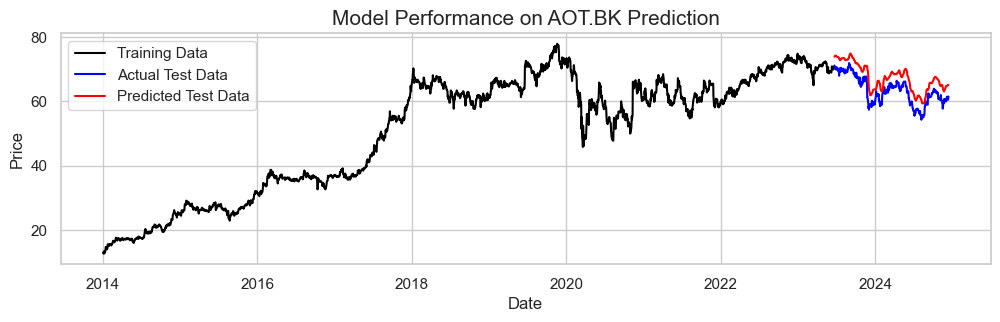

Starting tuning for BBL.BK...
Best Hyperparameters for BBL.BK:
 {'units_layer_1': 128, 'dropout_layer_1': 0.2, 'units_layer_2': 128, 'dropout_layer_2': 0.2, 'units_layer_3': 96, 'dropout_layer_3': 0.1, 'dense_units': 16, 'optimizer': 'rmsprop'}
                       0
units_layer_1        128
dropout_layer_1      0.2
units_layer_2        128
dropout_layer_2      0.2
units_layer_3         96
dropout_layer_3      0.1
dense_units           16
optimizer        rmsprop


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,113 (1.09 MB)

 Trainable params: 286,113 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - loss: 0.0679 - val_loss: 0.0735
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - loss: 0.0177 - val_loss: 0.0508
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - loss: 0.0138 - val_loss: 0.0303
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - loss: 0.0099 - val_loss: 0.0424
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - loss: 0.0126 - val_loss: 0.0458
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - loss: 0.0101 - val_loss: 0.0130
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - loss: 0.0063 - val_loss: 0.0433
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - loss: 0.0098 - val_loss: 0.0289
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - loss: 0.0066 - val_loss: 0.0138
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - loss: 0.0056 - val_loss: 0.0205
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - loss: 0.0060 - val_loss: 0.0290
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step 

<Figure size 640x480 with 0 Axes>

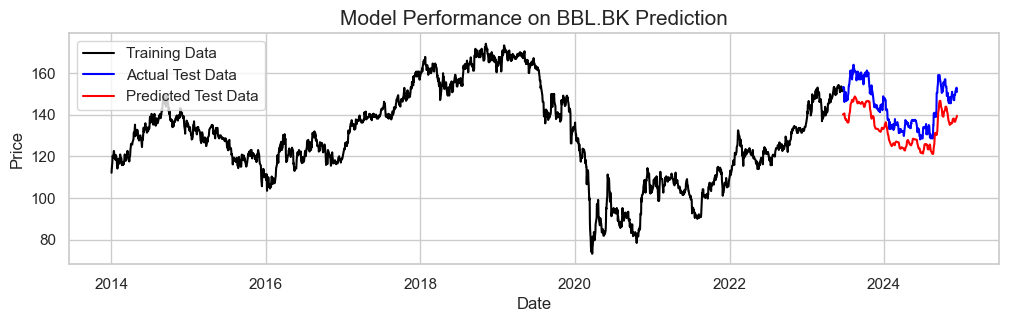

Starting tuning for BDMS.BK...
Best Hyperparameters for BDMS.BK:
 {'units_layer_1': 128, 'dropout_layer_1': 0.2, 'units_layer_2': 128, 'dropout_layer_2': 0.2, 'units_layer_3': 96, 'dropout_layer_3': 0.1, 'dense_units': 16, 'optimizer': 'rmsprop'}
                       0
units_layer_1        128
dropout_layer_1      0.2
units_layer_2        128
dropout_layer_2      0.2
units_layer_3         96
dropout_layer_3      0.1
dense_units           16
optimizer        rmsprop


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,113 (1.09 MB)

 Trainable params: 286,113 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - loss: 0.0561 - val_loss: 0.0321
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - loss: 0.0126 - val_loss: 0.0046
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step - loss: 0.0072 - val_loss: 0.1148
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - loss: 0.0066 - val_loss: 0.0408
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - loss: 0.0046 - val_loss: 0.1071
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 117ms/step - loss: 0.0056 - val_loss: 0.0044
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - loss: 0.0030 - val_loss: 0.0019
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - loss: 0.0032 - val_loss: 0.0107
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - loss: 0.0026 - val_loss: 0.0231
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - loss: 0.0027 - val_loss: 0.0875
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - loss: 0.0040 - val_loss: 0.0152
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step

<Figure size 640x480 with 0 Axes>

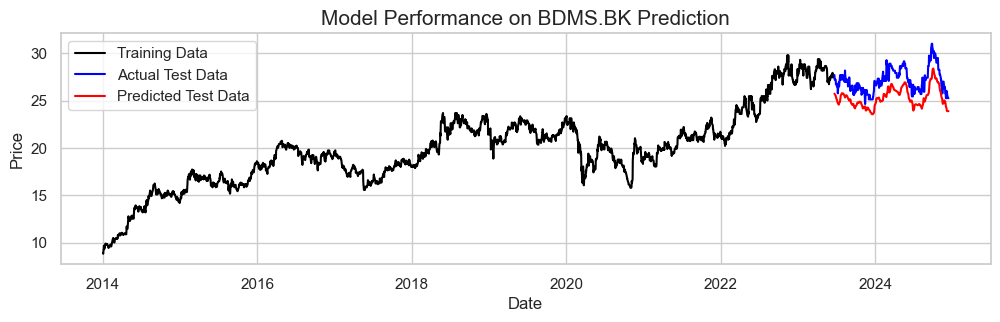

Starting tuning for BH.BK...
Best Hyperparameters for BH.BK:
 {'units_layer_1': 128, 'dropout_layer_1': 0.2, 'units_layer_2': 128, 'dropout_layer_2': 0.2, 'units_layer_3': 96, 'dropout_layer_3': 0.1, 'dense_units': 16, 'optimizer': 'rmsprop'}
                       0
units_layer_1        128
dropout_layer_1      0.2
units_layer_2        128
dropout_layer_2      0.2
units_layer_3         96
dropout_layer_3      0.1
dense_units           16
optimizer        rmsprop


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,113 (1.09 MB)

 Trainable params: 286,113 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - loss: 0.0489 - val_loss: 0.0389
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - loss: 0.0081 - val_loss: 0.0296
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - loss: 0.0059 - val_loss: 0.0036
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - loss: 0.0038 - val_loss: 0.0051
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - loss: 0.0042 - val_loss: 0.0054
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - loss: 0.0034 - val_loss: 0.0083
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - loss: 0.0024 - val_loss: 0.0029
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - loss: 0.0030 - val_loss: 0.0015
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - loss: 0.0024 - val_loss: 0.0126
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - loss: 0.0024 - val_loss: 0.0010
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - loss: 0.0018 - val_loss: 0.0022
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step

<Figure size 640x480 with 0 Axes>

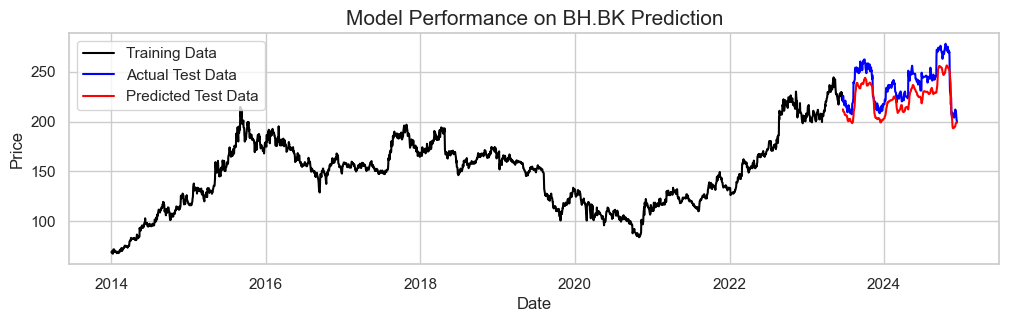

Starting tuning for CPALL.BK...
Best Hyperparameters for CPALL.BK:
 {'units_layer_1': 128, 'dropout_layer_1': 0.2, 'units_layer_2': 128, 'dropout_layer_2': 0.2, 'units_layer_3': 96, 'dropout_layer_3': 0.1, 'dense_units': 16, 'optimizer': 'rmsprop'}
                       0
units_layer_1        128
dropout_layer_1      0.2
units_layer_2        128
dropout_layer_2      0.2
units_layer_3         96
dropout_layer_3      0.1
dense_units           16
optimizer        rmsprop


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 16)             │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,113 (1.09 MB)

 Trainable params: 286,113 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 118ms/step - loss: 0.0628 - val_loss: 0.0047
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - loss: 0.0116 - val_loss: 0.0319
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 117ms/step - loss: 0.0099 - val_loss: 0.0481
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step - loss: 0.0094 - val_loss: 0.0318
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - loss: 0.0064 - val_loss: 0.0188
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - loss: 0.0056 - val_loss: 0.0126
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 117ms/step - loss: 0.0050 - val_loss: 0.0343
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - loss: 0.0060 - val_loss: 0.0198
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step - loss: 0.0045 - val_loss: 0.0194
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - loss: 0.0042 - val_loss: 0.0170
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - loss: 0.0038 - val_loss: 0.0193
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step

<Figure size 640x480 with 0 Axes>

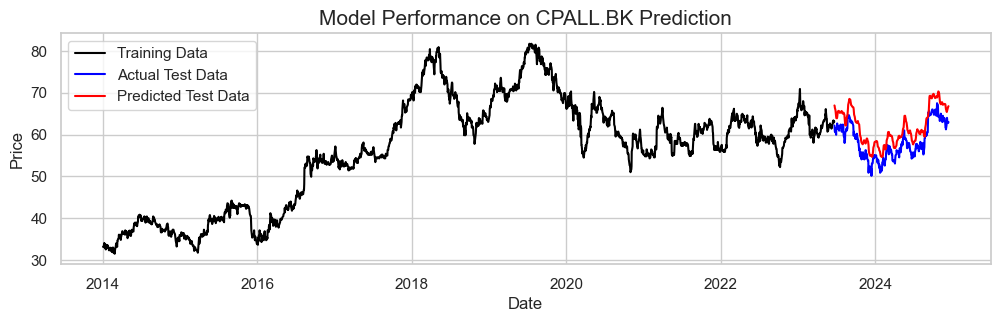

Starting tuning for CPF.BK...
Best Hyperparameters for CPF.BK:
 {'units_layer_1': 128, 'dropout_layer_1': 0.2, 'units_layer_2': 128, 'dropout_layer_2': 0.2, 'units_layer_3': 96, 'dropout_layer_3': 0.1, 'dense_units': 16, 'optimizer': 'rmsprop'}
                       0
units_layer_1        128
dropout_layer_1      0.2
units_layer_2        128
dropout_layer_2      0.2
units_layer_3         96
dropout_layer_3      0.1
dense_units           16
optimizer        rmsprop


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_22 (LSTM)                  │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 16)             │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,113 (1.09 MB)

 Trainable params: 286,113 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - loss: 0.0570 - val_loss: 0.0584
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - loss: 0.0135 - val_loss: 0.0258
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - loss: 0.0097 - val_loss: 0.0017
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - loss: 0.0076 - val_loss: 0.0154
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - loss: 0.0063 - val_loss: 0.0200
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step - loss: 0.0063 - val_loss: 0.0309
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - loss: 0.0063 - val_loss: 0.0121
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 117ms/step - loss: 0.0040 - val_loss: 0.0031
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - loss: 0.0047 - val_loss: 9.7139e-04
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step - loss: 0.0039 - val_loss: 0.0030
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/

<Figure size 640x480 with 0 Axes>

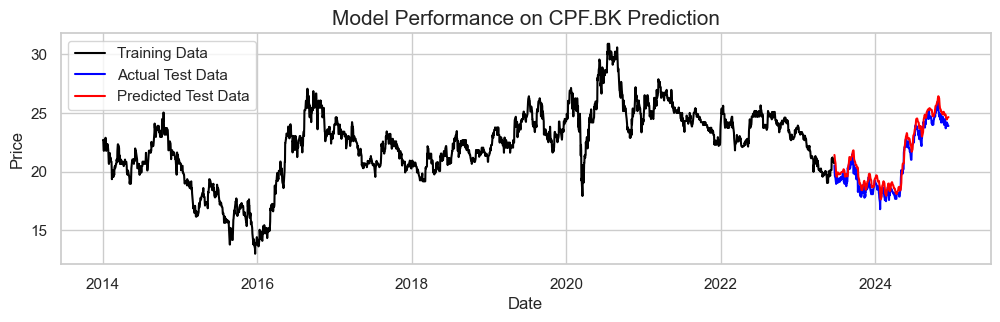

Starting tuning for CPN.BK...
Best Hyperparameters for CPN.BK:
 {'units_layer_1': 128, 'dropout_layer_1': 0.2, 'units_layer_2': 128, 'dropout_layer_2': 0.2, 'units_layer_3': 96, 'dropout_layer_3': 0.1, 'dense_units': 16, 'optimizer': 'rmsprop'}
                       0
units_layer_1        128
dropout_layer_1      0.2
units_layer_2        128
dropout_layer_2      0.2
units_layer_3         96
dropout_layer_3      0.1
dense_units           16
optimizer        rmsprop


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_24 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_26 (LSTM)                  │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 16)             │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,113 (1.09 MB)

 Trainable params: 286,113 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 106ms/step - loss: 0.0509 - val_loss: 0.0678
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - loss: 0.0165 - val_loss: 0.1098
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - loss: 0.0141 - val_loss: 0.0013
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - loss: 0.0077 - val_loss: 0.0398
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - loss: 0.0070 - val_loss: 0.0543
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - loss: 0.0077 - val_loss: 0.0161
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - loss: 0.0046 - val_loss: 0.0246
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - loss: 0.0052 - val_loss: 0.0107
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - loss: 0.0039 - val_loss: 0.0052
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - loss: 0.0035 - val_loss: 0.0162
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - loss: 0.0044 - val_loss: 0.0057
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/ste

<Figure size 640x480 with 0 Axes>

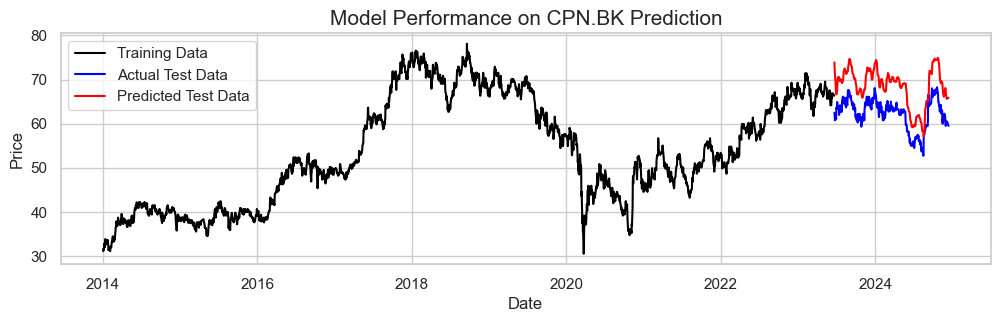

Starting tuning for DELTA.BK...
Best Hyperparameters for DELTA.BK:
 {'units_layer_1': 128, 'dropout_layer_1': 0.2, 'units_layer_2': 128, 'dropout_layer_2': 0.2, 'units_layer_3': 96, 'dropout_layer_3': 0.1, 'dense_units': 16, 'optimizer': 'rmsprop'}
                       0
units_layer_1        128
dropout_layer_1      0.2
units_layer_2        128
dropout_layer_2      0.2
units_layer_3         96
dropout_layer_3      0.1
dense_units           16
optimizer        rmsprop


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_27 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_28 (LSTM)                  │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_29 (LSTM)                  │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 16)             │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,113 (1.09 MB)

 Trainable params: 286,113 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 111ms/step - loss: 0.0059 - val_loss: 0.0086
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - loss: 0.0012 - val_loss: 0.0040
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - loss: 9.8426e-04 - val_loss: 0.0047
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - loss: 8.0097e-04 - val_loss: 0.0074
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - loss: 6.7671e-04 - val_loss: 0.0056
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - loss: 6.6333e-04 - val_loss: 0.0065
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - loss: 5.5363e-04 - val_loss: 0.0050
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - loss: 5.2597e-04 - val_loss: 0.0069
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - loss: 5.4564e-04 - val_loss: 0.0053
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - loss: 5.6227e-04 - val_loss: 0.0066
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - loss: 4.4127e-04 - val_loss: 0.0058
Epoch 12/50
57/5

<Figure size 640x480 with 0 Axes>

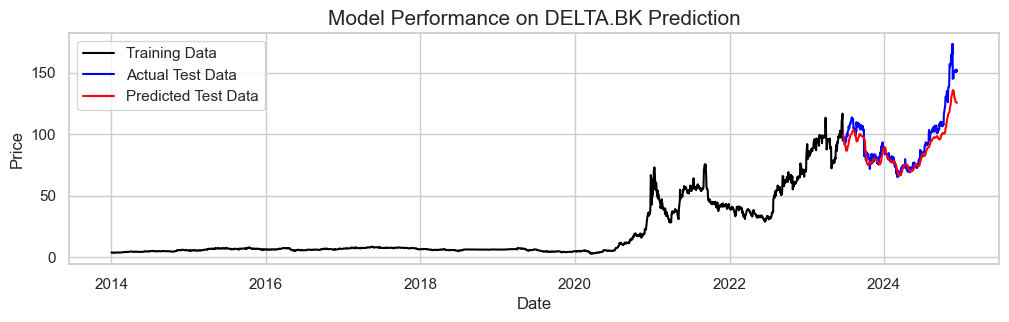

Starting tuning for HMPRO.BK...
Best Hyperparameters for HMPRO.BK:
 {'units_layer_1': 128, 'dropout_layer_1': 0.2, 'units_layer_2': 128, 'dropout_layer_2': 0.2, 'units_layer_3': 96, 'dropout_layer_3': 0.1, 'dense_units': 16, 'optimizer': 'rmsprop'}
                       0
units_layer_1        128
dropout_layer_1      0.2
units_layer_2        128
dropout_layer_2      0.2
units_layer_3         96
dropout_layer_3      0.1
dense_units           16
optimizer        rmsprop


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_30 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_31 (LSTM)                  │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_32 (LSTM)                  │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 16)             │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,113 (1.09 MB)

 Trainable params: 286,113 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 109ms/step - loss: 0.0799 - val_loss: 0.0976
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - loss: 0.0167 - val_loss: 0.0203
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - loss: 0.0076 - val_loss: 0.0239
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - loss: 0.0073 - val_loss: 0.0013
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - loss: 0.0055 - val_loss: 0.0221
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - loss: 0.0059 - val_loss: 0.0198
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - loss: 0.0048 - val_loss: 0.0106
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - loss: 0.0042 - val_loss: 0.0634
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - loss: 0.0061 - val_loss: 0.0217
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - loss: 0.0044 - val_loss: 0.0233
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - loss: 0.0039 - val_loss: 0.0734
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step

<Figure size 640x480 with 0 Axes>

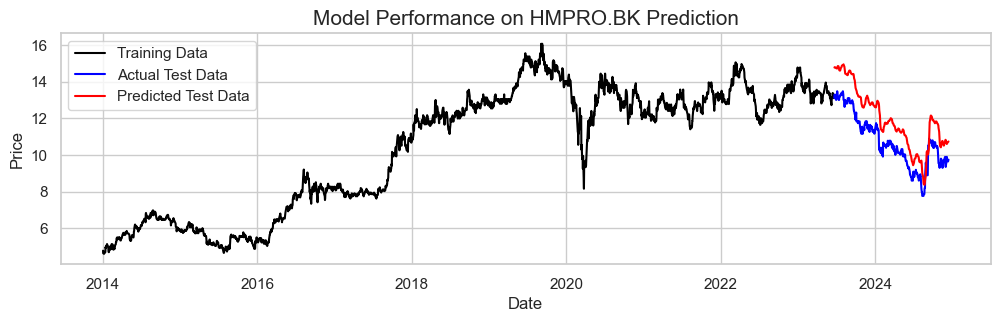

Starting tuning for INTUCH.BK...
Best Hyperparameters for INTUCH.BK:
 {'units_layer_1': 128, 'dropout_layer_1': 0.2, 'units_layer_2': 128, 'dropout_layer_2': 0.2, 'units_layer_3': 96, 'dropout_layer_3': 0.1, 'dense_units': 16, 'optimizer': 'rmsprop'}
                       0
units_layer_1        128
dropout_layer_1      0.2
units_layer_2        128
dropout_layer_2      0.2
units_layer_3         96
dropout_layer_3      0.1
dense_units           16
optimizer        rmsprop


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_33 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_34 (LSTM)                  │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_35 (LSTM)                  │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 16)             │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,113 (1.09 MB)

 Trainable params: 286,113 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 117ms/step - loss: 0.0187 - val_loss: 0.0028
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - loss: 0.0048 - val_loss: 0.0028
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - loss: 0.0034 - val_loss: 0.0071
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - loss: 0.0026 - val_loss: 0.0043
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - loss: 0.0021 - val_loss: 0.0053
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - loss: 0.0023 - val_loss: 0.0028
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - loss: 0.0019 - val_loss: 0.0024
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - loss: 0.0018 - val_loss: 0.0037
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - loss: 0.0014 - val_loss: 0.0023
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step

<Figure size 640x480 with 0 Axes>

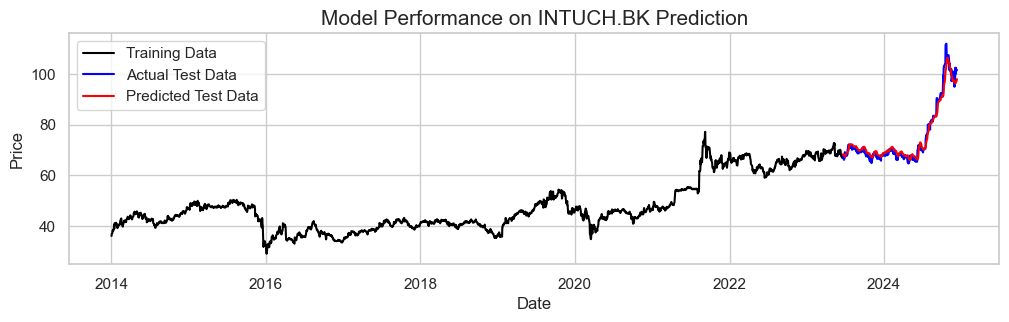

Starting tuning for IVL.BK...
Best Hyperparameters for IVL.BK:
 {'units_layer_1': 128, 'dropout_layer_1': 0.2, 'units_layer_2': 128, 'dropout_layer_2': 0.2, 'units_layer_3': 96, 'dropout_layer_3': 0.1, 'dense_units': 16, 'optimizer': 'rmsprop'}
                       0
units_layer_1        128
dropout_layer_1      0.2
units_layer_2        128
dropout_layer_2      0.2
units_layer_3         96
dropout_layer_3      0.1
dense_units           16
optimizer        rmsprop


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_36 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_37 (LSTM)                  │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_38 (LSTM)                  │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 16)             │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,113 (1.09 MB)

 Trainable params: 286,113 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - loss: 0.0482 - val_loss: 0.2384
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - loss: 0.0144 - val_loss: 0.1123
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - loss: 0.0089 - val_loss: 0.1889
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - loss: 0.0110 - val_loss: 0.2110
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - loss: 0.0121 - val_loss: 0.1087
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - loss: 0.0063 - val_loss: 0.1790
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - loss: 0.0092 - val_loss: 0.2903
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - loss: 0.0141 - val_loss: 0.0855
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - loss: 0.0051 - val_loss: 0.0018
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - loss: 0.0037 - val_loss: 0.1088
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - loss: 0.0065 - val_loss: 0.0728
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step 

<Figure size 640x480 with 0 Axes>

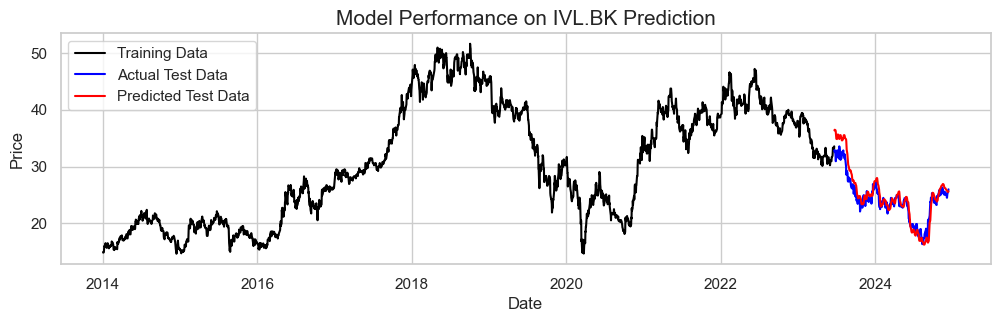

Starting tuning for KBANK.BK...
Best Hyperparameters for KBANK.BK:
 {'units_layer_1': 128, 'dropout_layer_1': 0.2, 'units_layer_2': 128, 'dropout_layer_2': 0.2, 'units_layer_3': 96, 'dropout_layer_3': 0.1, 'dense_units': 16, 'optimizer': 'rmsprop'}
                       0
units_layer_1        128
dropout_layer_1      0.2
units_layer_2        128
dropout_layer_2      0.2
units_layer_3         96
dropout_layer_3      0.1
dense_units           16
optimizer        rmsprop


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_39 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_40 (LSTM)                  │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_41 (LSTM)                  │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 16)             │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,113 (1.09 MB)

 Trainable params: 286,113 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - loss: 0.0740 - val_loss: 0.0040
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - loss: 0.0145 - val_loss: 0.0623
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - loss: 0.0138 - val_loss: 0.0064
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - loss: 0.0074 - val_loss: 0.0391
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - loss: 0.0094 - val_loss: 0.0451
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - loss: 0.0098 - val_loss: 0.0018
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - loss: 0.0071 - val_loss: 0.0131
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - loss: 0.0055 - val_loss: 0.0328
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - loss: 0.0071 - val_loss: 0.0114
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - loss: 0.0059 - val_loss: 0.0067
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - loss: 0.0038 - val_loss: 0.0053
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step

<Figure size 640x480 with 0 Axes>

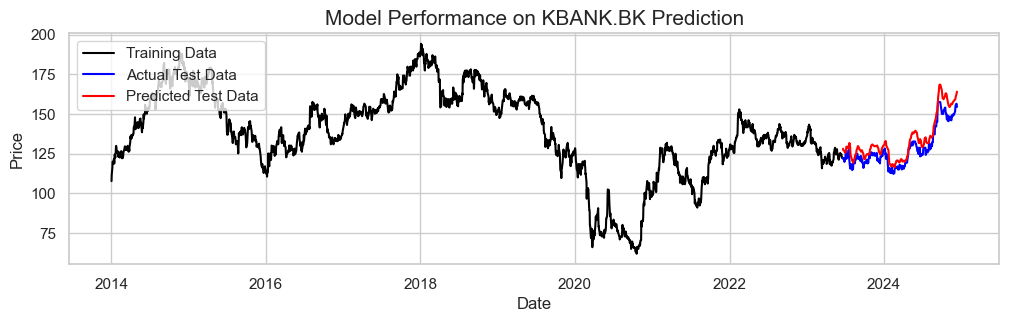

Starting tuning for KTB.BK...
Best Hyperparameters for KTB.BK:
 {'units_layer_1': 128, 'dropout_layer_1': 0.2, 'units_layer_2': 128, 'dropout_layer_2': 0.2, 'units_layer_3': 96, 'dropout_layer_3': 0.1, 'dense_units': 16, 'optimizer': 'rmsprop'}
                       0
units_layer_1        128
dropout_layer_1      0.2
units_layer_2        128
dropout_layer_2      0.2
units_layer_3         96
dropout_layer_3      0.1
dense_units           16
optimizer        rmsprop


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_42 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_43 (LSTM)                  │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_44 (LSTM)                  │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 16)             │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,113 (1.09 MB)

 Trainable params: 286,113 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step - loss: 0.0640 - val_loss: 0.0825
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - loss: 0.0173 - val_loss: 0.0830
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - loss: 0.0153 - val_loss: 0.0370
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - loss: 0.0089 - val_loss: 0.0373
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - loss: 0.0087 - val_loss: 0.0708
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 117ms/step - loss: 0.0098 - val_loss: 0.0012
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - loss: 0.0043 - val_loss: 0.0225
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - loss: 0.0056 - val_loss: 0.0111
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - loss: 0.0041 - val_loss: 0.0115
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - loss: 0.0035 - val_loss: 0.0019
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - loss: 0.0025 - val_loss: 0.0126
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step

<Figure size 640x480 with 0 Axes>

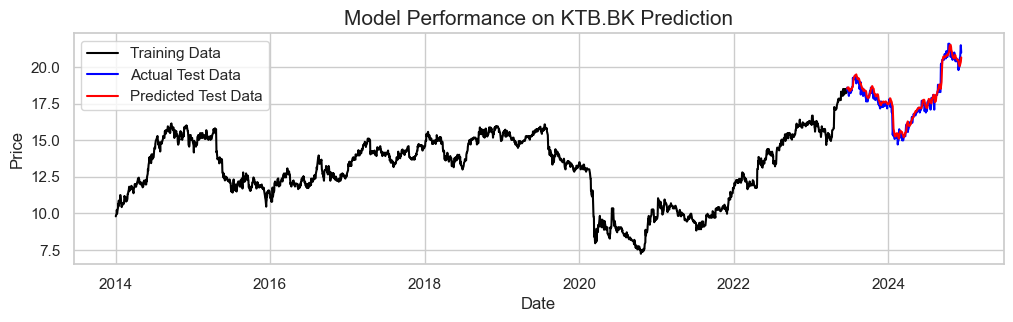

Starting tuning for MINT.BK...
Best Hyperparameters for MINT.BK:
 {'units_layer_1': 128, 'dropout_layer_1': 0.2, 'units_layer_2': 128, 'dropout_layer_2': 0.2, 'units_layer_3': 96, 'dropout_layer_3': 0.1, 'dense_units': 16, 'optimizer': 'rmsprop'}
                       0
units_layer_1        128
dropout_layer_1      0.2
units_layer_2        128
dropout_layer_2      0.2
units_layer_3         96
dropout_layer_3      0.1
dense_units           16
optimizer        rmsprop


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_45 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_46 (LSTM)                  │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_47 (LSTM)                  │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 16)             │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,113 (1.09 MB)

 Trainable params: 286,113 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 117ms/step - loss: 0.1004 - val_loss: 0.0125
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - loss: 0.0185 - val_loss: 0.0323
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 0.0130 - val_loss: 0.0235
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - loss: 0.0106 - val_loss: 0.0459
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - loss: 0.0114 - val_loss: 0.0389
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - loss: 0.0092 - val_loss: 0.1051
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - loss: 0.0141 - val_loss: 0.0478
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - loss: 0.0084 - val_loss: 0.0315
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - loss: 0.0072 - val_loss: 0.0043
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - loss: 0.0060 - val_loss: 0.0136
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - loss: 0.0059 - val_loss: 0.0229
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - loss: 

<Figure size 640x480 with 0 Axes>

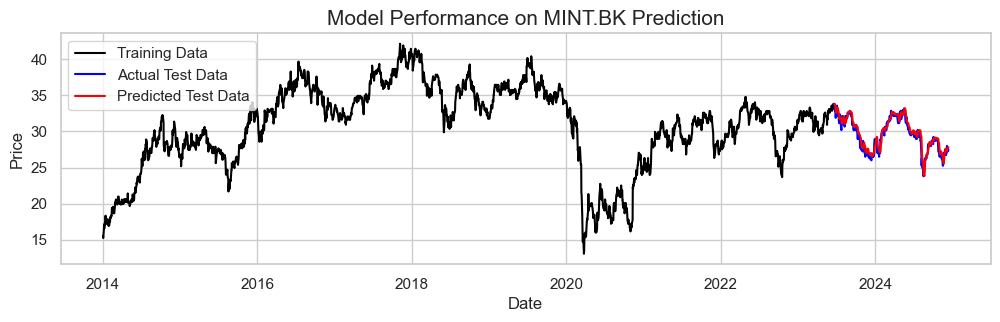

Starting tuning for PTT.BK...
Best Hyperparameters for PTT.BK:
 {'units_layer_1': 128, 'dropout_layer_1': 0.2, 'units_layer_2': 128, 'dropout_layer_2': 0.2, 'units_layer_3': 96, 'dropout_layer_3': 0.1, 'dense_units': 16, 'optimizer': 'rmsprop'}
                       0
units_layer_1        128
dropout_layer_1      0.2
units_layer_2        128
dropout_layer_2      0.2
units_layer_3         96
dropout_layer_3      0.1
dense_units           16
optimizer        rmsprop


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_48 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_49 (LSTM)                  │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_50 (LSTM)                  │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 16)             │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,113 (1.09 MB)

 Trainable params: 286,113 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.0638 - val_loss: 0.0877
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - loss: 0.0188 - val_loss: 0.0769
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - loss: 0.0142 - val_loss: 0.0459
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - loss: 0.0100 - val_loss: 0.1305
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - loss: 0.0143 - val_loss: 0.0651
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - loss: 0.0092 - val_loss: 0.0051
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - loss: 0.0062 - val_loss: 0.0457
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - loss: 0.0072 - val_loss: 0.1331
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - loss: 0.0113 - val_loss: 0.0699
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - loss: 0.0077 - val_loss: 0.0550
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - loss: 0.0068 - val_loss: 0.0861
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 0.

<Figure size 640x480 with 0 Axes>

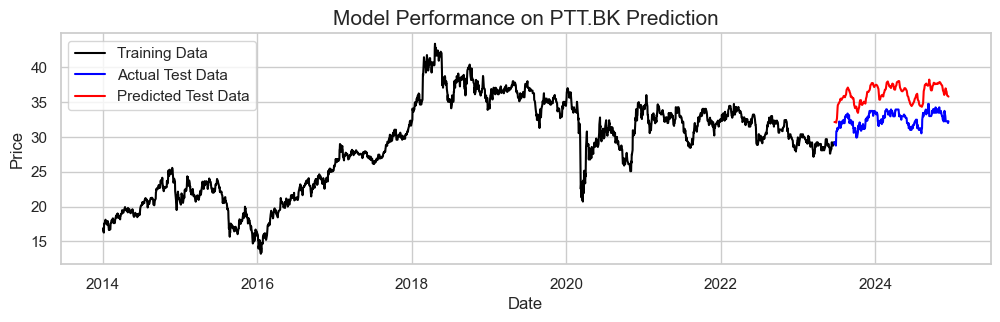

Starting tuning for PTTEP.BK...
Best Hyperparameters for PTTEP.BK:
 {'units_layer_1': 128, 'dropout_layer_1': 0.2, 'units_layer_2': 128, 'dropout_layer_2': 0.2, 'units_layer_3': 96, 'dropout_layer_3': 0.1, 'dense_units': 16, 'optimizer': 'rmsprop'}
                       0
units_layer_1        128
dropout_layer_1      0.2
units_layer_2        128
dropout_layer_2      0.2
units_layer_3         96
dropout_layer_3      0.1
dense_units           16
optimizer        rmsprop


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_51 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_52 (LSTM)                  │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_53 (LSTM)                  │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 16)             │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,113 (1.09 MB)

 Trainable params: 286,113 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - loss: 0.0308 - val_loss: 0.0925
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 0.0125 - val_loss: 0.0872
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - loss: 0.0106 - val_loss: 0.0719
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 0.0084 - val_loss: 0.1263
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 0.0105 - val_loss: 0.0654
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 0.0075 - val_loss: 0.0603
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 0.0062 - val_loss: 0.0503
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - loss: 0.0057 - val_loss: 0.0174
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - loss: 0.0032 - val_loss: 0.0169
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - loss: 0.0033 - val_loss: 0.0131
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 0.0023 - val_loss: 0.0384
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - loss: 0.0

<Figure size 640x480 with 0 Axes>

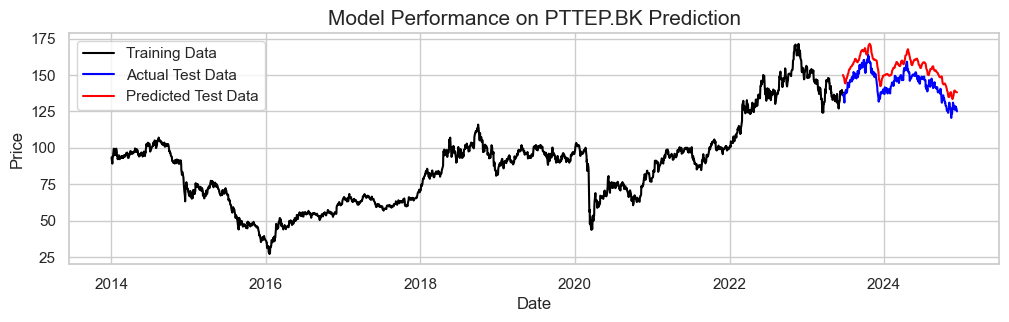

Starting tuning for SCC.BK...
Best Hyperparameters for SCC.BK:
 {'units_layer_1': 128, 'dropout_layer_1': 0.2, 'units_layer_2': 128, 'dropout_layer_2': 0.2, 'units_layer_3': 96, 'dropout_layer_3': 0.1, 'dense_units': 16, 'optimizer': 'rmsprop'}
                       0
units_layer_1        128
dropout_layer_1      0.2
units_layer_2        128
dropout_layer_2      0.2
units_layer_3         96
dropout_layer_3      0.1
dense_units           16
optimizer        rmsprop


Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_54 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_55 (LSTM)                  │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_56 (LSTM)                  │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 16)             │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,113 (1.09 MB)

 Trainable params: 286,113 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - loss: 0.1063 - val_loss: 0.0272
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 0.0183 - val_loss: 0.0586
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 0.0148 - val_loss: 0.0198
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - loss: 0.0106 - val_loss: 0.0021
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - loss: 0.0087 - val_loss: 0.0142
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 0.0080 - val_loss: 0.0033
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - loss: 0.0061 - val_loss: 0.0018
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - loss: 0.0059 - val_loss: 0.0014
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - loss: 0.0046 - val_loss: 0.0413
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - loss: 0.0076 - val_loss: 0.0087
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - loss: 0.0056 - val_loss: 0.0017
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - loss: 0.0

<Figure size 640x480 with 0 Axes>

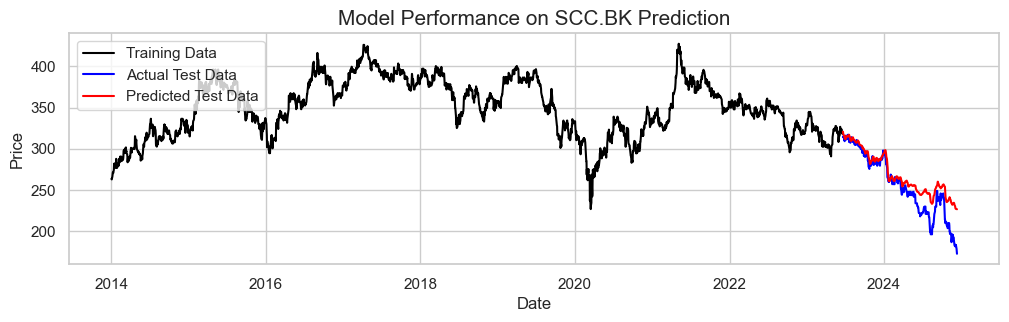

Starting tuning for TRUE.BK...
Best Hyperparameters for TRUE.BK:
 {'units_layer_1': 128, 'dropout_layer_1': 0.2, 'units_layer_2': 128, 'dropout_layer_2': 0.2, 'units_layer_3': 96, 'dropout_layer_3': 0.1, 'dense_units': 16, 'optimizer': 'rmsprop'}
                       0
units_layer_1        128
dropout_layer_1      0.2
units_layer_2        128
dropout_layer_2      0.2
units_layer_3         96
dropout_layer_3      0.1
dense_units           16
optimizer        rmsprop


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_57 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_58 (LSTM)                  │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_59 (LSTM)                  │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 16)             │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,113 (1.09 MB)

 Trainable params: 286,113 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - loss: 0.0390 - val_loss: 0.0089
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - loss: 0.0059 - val_loss: 0.0097
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - loss: 0.0046 - val_loss: 0.0023
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - loss: 0.0037 - val_loss: 0.0025
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - loss: 0.0027 - val_loss: 0.0039
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - loss: 0.0022 - val_loss: 0.0027
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 0.0021 - val_loss: 0.0031
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - loss:

<Figure size 640x480 with 0 Axes>

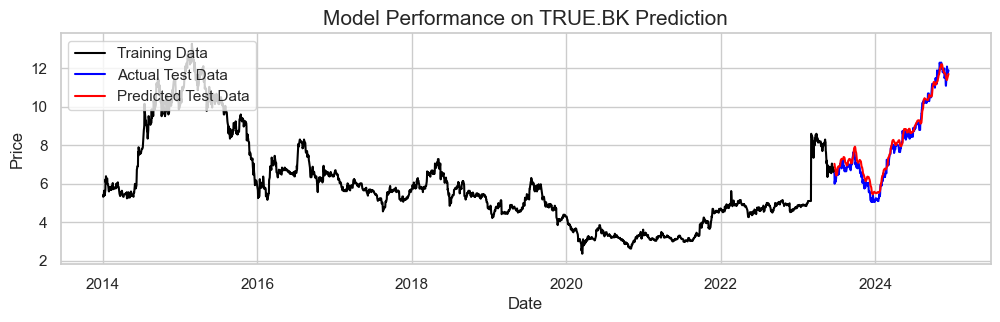

Starting tuning for TTB.BK...
Best Hyperparameters for TTB.BK:
 {'units_layer_1': 128, 'dropout_layer_1': 0.2, 'units_layer_2': 128, 'dropout_layer_2': 0.2, 'units_layer_3': 96, 'dropout_layer_3': 0.1, 'dense_units': 16, 'optimizer': 'rmsprop'}
                       0
units_layer_1        128
dropout_layer_1      0.2
units_layer_2        128
dropout_layer_2      0.2
units_layer_3         96
dropout_layer_3      0.1
dense_units           16
optimizer        rmsprop


Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_60 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_61 (LSTM)                  │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_62 (LSTM)                  │ (None, 96)             │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 16)             │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,113 (1.09 MB)

 Trainable params: 286,113 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0744 - val_loss: 0.0251
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - loss: 0.0141 - val_loss: 0.0146
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - loss: 0.0098 - val_loss: 0.0160
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - loss: 0.0085 - val_loss: 0.0021
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - loss: 0.0065 - val_loss: 0.0129
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - loss: 0.0064 - val_loss: 0.0134
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 0.0076 - val_loss: 0.0141
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - loss: 0.0068 - val_loss: 0.0106
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - loss: 0.0056 - val_loss: 0.0033
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - loss: 0.0047 - val_loss: 0.0076
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - loss: 0.0045 - val_loss: 0.0130
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - loss:

<Figure size 640x480 with 0 Axes>

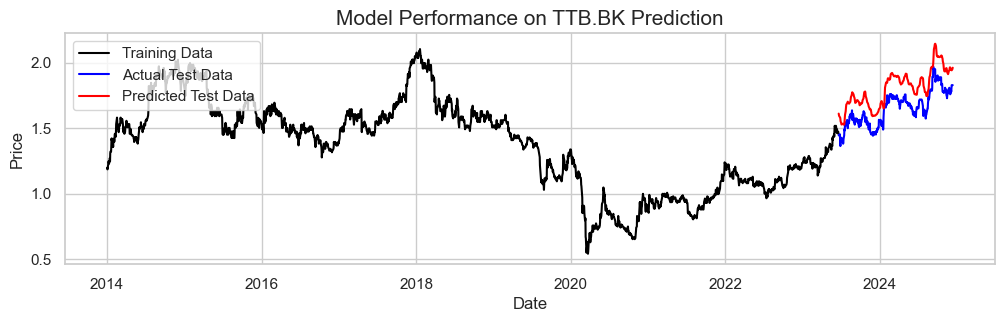

Total time taken for the entire process: 6685.729485034943 seconds


<Figure size 640x480 with 0 Axes>

In [24]:
SET1_results = find_fit_eva(df=set1, test_size=test_size, results=results, tuner=tuner, define_model=define_model)

**Saving Model**

In [1]:
# SET1_results[0] into a single DataFrame
SET1_results_df = pd.concat(
    [df.assign(stock=stock) for stock, df in SET1_results[0].items()],
    ignore_index=True)

# Export
SET1_results_df.to_csv("../Data/SET1_hyper_df.csv", index=False)

NameError: name 'pd' is not defined

In [52]:
predictions = SET1_results[1]
predictions_df = pd.DataFrame({stock: pred.ravel() for stock, pred in predictions.items()})

# Export
predictions_df.to_csv("../Data/predictions_set.csv", index=False)

In [70]:
import keras
import os
models_ = SET1_results[2]
# Creating a directory to save models
os.makedirs('models', exist_ok=True)

# Loop through each stock model
for stock, model in models_.items():
    model_filename = f'models/{stock}_model.keras' 
    model.save(model_filename)
    print(f"Model for {stock} saved to {model_filename}")

Model for ADVANC.BK saved to models/ADVANC.BK_model.keras
Model for AOT.BK saved to models/AOT.BK_model.keras
Model for BBL.BK saved to models/BBL.BK_model.keras
Model for BDMS.BK saved to models/BDMS.BK_model.keras
Model for BH.BK saved to models/BH.BK_model.keras
Model for CPALL.BK saved to models/CPALL.BK_model.keras
Model for CPF.BK saved to models/CPF.BK_model.keras
Model for CPN.BK saved to models/CPN.BK_model.keras
Model for DELTA.BK saved to models/DELTA.BK_model.keras
Model for HMPRO.BK saved to models/HMPRO.BK_model.keras
Model for INTUCH.BK saved to models/INTUCH.BK_model.keras
Model for IVL.BK saved to models/IVL.BK_model.keras
Model for KBANK.BK saved to models/KBANK.BK_model.keras
Model for KTB.BK saved to models/KTB.BK_model.keras
Model for MINT.BK saved to models/MINT.BK_model.keras
Model for PTT.BK saved to models/PTT.BK_model.keras
Model for PTTEP.BK saved to models/PTTEP.BK_model.keras
Model for SCC.BK saved to models/SCC.BK_model.keras
Model for TRUE.BK saved to mod

**Expected Return**

In [56]:
forecasted_returns_pct_list = []
for column in predictions_df.columns:
    # Correctly get the first and last value using .iloc
    forecasted_returns = (predictions_df[column].iloc[-1] - predictions_df[column].iloc[0]) / predictions_df[column].iloc[0]
    forecasted_returns_pct = forecasted_returns * 100
    forecasted_returns_pct_list.append(forecasted_returns_pct)

# Create a DataFrame from the list
forecasted_returns_df = pd.DataFrame(forecasted_returns_pct_list, index=predictions_df.columns, columns=["Expected Return (%)"])

# Find the top 10 highest returns
top_10_returns = forecasted_returns_df.sort_values(by="Expected Return (%)", ascending=False).head(10)
top_10_returns.to_csv("../Data/top_10_returns_SET1.csv")